# Sensitivity

Our final step is to calculate the sensitivity of the JUNO detector to the mass hierarchy problem. We have not considered the systematic uncertainties yet, because they are too complicated, and they need a lot of computing resources. For now we only consider the statistical uncertainties.

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt

from neutrino_survival import NeutrinoSurvival
from ibd_kinematics import StrumiaVissani
from detector_response import JUNODetector
from neutrino_flux import NeutrinoFlux
from signal_and_background import JUNOSignalAndBackground

# Build the cross section table and detector response
sv = StrumiaVissani()
E_nu_grid = np.linspace(1.8, 15.0, 5000)  # MeV
sv.build_total_cross_section_table(E_nu_grid)
detector = JUNODetector(sv)
detector.load_response_matrix()

Building total cross section table: 100%|██████████| 5000/5000 [00:09<00:00, 510.77it/s]


Response matrix loaded from juno_detector_response_matrix_79665791.npz


We need to fit three free parameters: $\Delta m_{21}^2$, $\Delta m_{32}^2$, $\sin^2 \theta_{12}$. An additional term is a constraint parameter, $\sin^2 \theta_{13} = (2.18 \pm 0.07) \times 10^{-2}$.

In [2]:
def get_signal_and_bkg(
    delta_m21_squared,
    delta_m32_squared,
    s_theta_12_squared,
    s_theta_13_squared,
    exposure_years=6.5,
):
    # Create NeutrinoSurvival and NeutrinoFlux instances with given parameters
    if delta_m32_squared > 0:
        hierarchy = "normal"
    else:
        hierarchy = "inverted"
    ns = NeutrinoSurvival(
        delta_m21_squared=delta_m21_squared,
        delta_m32_squared=[np.abs(delta_m32_squared), -np.abs(delta_m32_squared)],
        s_theta_12_squared=s_theta_12_squared,
        s_theta_13_squared=s_theta_13_squared,
        rho=2.45,
    )
    nf = NeutrinoFlux(ns, sv)
    # Create JUNOSignalAndBackground instance and calculate expected events
    signal_and_bkg = JUNOSignalAndBackground(
        ns, sv, detector, nf, exposure_years=exposure_years
    )
    bin_counts = signal_and_bkg.calculate_expected_events(hierarchy=hierarchy)
    return bin_counts

In [3]:
data_normal_asimov = get_signal_and_bkg(
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
    delta_m21_squared=7.53e-5,
    # delta_m32_squared=[2.453e-3, -2.546e-3],
    delta_m32_squared=2.453e-3,
    exposure_years=6.5,
)
data_inverted_asimov = get_signal_and_bkg(
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
    delta_m21_squared=7.53e-5,
    # delta_m32_squared=[2.453e-3, -2.546e-3],
    delta_m32_squared=-2.546e-3,
    exposure_years=6.5,
)

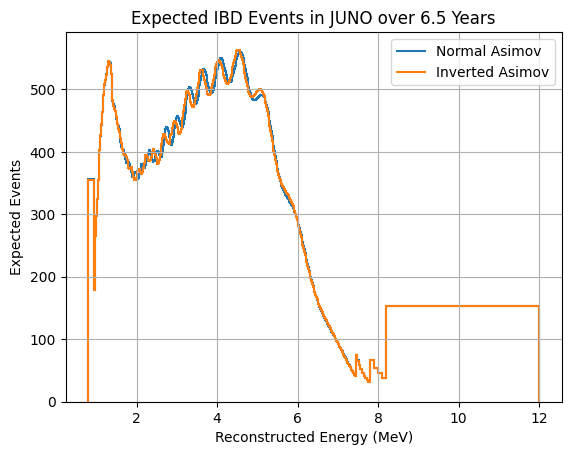

In [4]:
bin_edges = (
    [
        0.8,
    ]
    + list(np.arange(0.94, 7.43, 0.02))
    + list(np.arange(7.44, 7.79, 0.04))
    + list(np.arange(7.80, 8.21, 0.10))
    + [12.0]
)
bin_edges = np.array(bin_edges)  # MeV

plt.stairs(data_normal_asimov, bin_edges, label="Normal Asimov", linewidth=1.5)
plt.stairs(data_inverted_asimov, bin_edges, label="Inverted Asimov", linewidth=1.5)
plt.xlabel("Reconstructed Energy (MeV)")
plt.ylabel("Expected Events")
plt.title("Expected IBD Events in JUNO over 6.5 Years")
plt.legend()
plt.grid()
plt.show()

In [5]:
# We define a cost function to be used in iminuit
def cost_function_normal(
    delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
):
    bin_counts = get_signal_and_bkg(
        delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
    )
    # Here we would compare bin_counts to some observed data to compute chi-square or likelihood
    chi2 = np.sum(
        (data_normal_asimov - bin_counts) ** 2 / (bin_counts + 1e-10)
    )  # Adding small number to avoid division by zero

    # We also add a Gaussian prior on s_theta_13_squared
    s_theta_13_prior_mean = 0.0218
    s_theta_13_prior_sigma = 0.0007
    chi2 += ((s_theta_13_squared - s_theta_13_prior_mean) / s_theta_13_prior_sigma) ** 2

    return chi2


def cost_function_inverted(
    delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
):
    bin_counts = get_signal_and_bkg(
        delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
    )
    # Here we would compare bin_counts to some observed data to compute chi-square or likelihood
    chi2 = np.sum(
        (data_inverted_asimov - bin_counts) ** 2 / (bin_counts + 1e-10)
    )  # Adding small number to avoid division by zero

    # We also add a Gaussian prior on s_theta_13_squared
    s_theta_13_prior_mean = 0.0218
    s_theta_13_prior_sigma = 0.0007
    chi2 += ((s_theta_13_squared - s_theta_13_prior_mean) / s_theta_13_prior_sigma) ** 2

    return chi2

In [6]:
# Now we can use iminuit to minimize the cost_function
from iminuit import Minuit

m_normal = Minuit(
    cost_function_normal,
    delta_m32_squared=-2.546e-3,
    delta_m21_squared=7.53e-5,
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
)
m_normal.limits["delta_m21_squared"] = (0, 1e-4)
m_normal.limits["delta_m32_squared"] = (-1e-2, 0)

m_normal.limits["s_theta_12_squared"] = (0, 1)
m_normal.limits["s_theta_13_squared"] = (0, 1)
m_normal.migrad()  # Perform the minimization

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.71                      │              Nfcn = 79               │
│ EDM = 5.82e-05 (Goal: 0.0002)    │            time = 2.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ delta_m21_squared  │ 75.30e-6  │  0.12e-6  │            │            │    0    │ 0.0001  │       │
│ 1 │ delta_m32_squared  │ -2.579e-3 │ 0.004e-3  │            │            │  -0.01  │    0    │       │
│ 2 │ s_theta_12_squared │ 307.0e-3  │  0.8e-3   │            │            │    0    │    1    │       │
│ 3 │ s_theta_13_squared │  21.7e-3  │  0.7e-3   │            │            │    0    │    1    │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│                    │  delta_m21_squared  delta_m32_squared s_theta_12_squared s_theta_13_squared │
├────────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│  delta_m21_squared │           1.38e-14         -0.015e-12        -25.873e-12         -4.961e-12 │
│  delta_m32_squared │         -0.015e-12           1.61e-11           0.056e-9          -0.010e-9 │
│ s_theta_12_squared │        -25.873e-12           0.056e-9           6.36e-07            -0.2e-6 │
│ s_theta_13_squared │         -4.961e-12          -0.010e-9            -0.2e-6           4.25e-07 │
└────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

In [7]:
m_inverted = Minuit(
    cost_function_inverted,
    delta_m32_squared=2.453e-3,
    delta_m21_squared=7.53e-5,
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
)
m_inverted.limits["delta_m21_squared"] = (0, 1e-4)
m_inverted.limits["delta_m32_squared"] = (0, 1e-2)

m_inverted.limits["s_theta_12_squared"] = (0, 1)
m_inverted.limits["s_theta_13_squared"] = (0, 1)
m_inverted.migrad()  # Perform the minimization

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.33                      │              Nfcn = 79               │
│ EDM = 4.9e-05 (Goal: 0.0002)     │            time = 1.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ delta_m21_squared  │ 75.30e-6  │  0.12e-6  │            │            │    0    │ 0.0001  │       │
│ 1 │ delta_m32_squared  │ 2.420e-3  │ 0.004e-3  │            │            │    0    │  0.01   │       │
│ 2 │ s_theta_12_squared │ 307.0e-3  │  0.8e-3   │            │            │    0    │    1    │       │
│ 3 │ s_theta_13_squared │  21.7e-3  │  0.7e-3   │            │            │    0    │    1    │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│                    │  delta_m21_squared  delta_m32_squared s_theta_12_squared s_theta_13_squared │
├────────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│  delta_m21_squared │           1.38e-14         -0.015e-12        -25.889e-12         -4.952e-12 │
│  delta_m32_squared │         -0.015e-12           1.58e-11           0.057e-9           0.012e-9 │
│ s_theta_12_squared │        -25.889e-12           0.057e-9           6.36e-07            -0.1e-6 │
│ s_theta_13_squared │         -4.952e-12           0.012e-9            -0.1e-6           4.25e-07 │
└────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

In [ ]:
print("Minimum chi-square (normal):", m_normal.fval)  # Expected 11.5
print("Best-fit parameters (normal):", m_normal.values)
print("Minimum chi-square (inverted):", m_inverted.fval)
print("Best-fit parameters (inverted):", m_inverted.values)

Minimum chi-square (normal): 10.707203928296252
Best-fit parameters (normal): <ValueView delta_m21_squared=7.529866283630099e-05 delta_m32_squared=-0.0025785316097413054 s_theta_12_squared=0.30701421410740903 s_theta_13_squared=0.02166393977663808>
Minimum chi-square (inverted): 11.334678802710663
Best-fit parameters (inverted): <ValueView delta_m21_squared=7.529847945425666e-05 delta_m32_squared=0.002420410856209226 s_theta_12_squared=0.3070105132711776 s_theta_13_squared=0.0217317801561622>


It is interesting to see the effect of the MSW effect. We disable the MSW effect by setting $\rho = 0$

In [9]:
def get_signal_and_bkg_no_msw(
    delta_m21_squared,
    delta_m32_squared,
    s_theta_12_squared,
    s_theta_13_squared,
    exposure_years=6.5,
):
    # Create NeutrinoSurvival and NeutrinoFlux instances with given parameters
    if delta_m32_squared > 0:
        hierarchy = "normal"
    else:
        hierarchy = "inverted"
    ns = NeutrinoSurvival(
        delta_m21_squared=delta_m21_squared,
        delta_m32_squared=[np.abs(delta_m32_squared), -np.abs(delta_m32_squared)],
        s_theta_12_squared=s_theta_12_squared,
        s_theta_13_squared=s_theta_13_squared,
        rho=0.0,
    )
    nf = NeutrinoFlux(ns, sv)
    # Create JUNOSignalAndBackground instance and calculate expected events
    signal_and_bkg = JUNOSignalAndBackground(
        ns, sv, detector, nf, exposure_years=exposure_years
    )
    bin_counts = signal_and_bkg.calculate_expected_events(hierarchy=hierarchy)
    return bin_counts


data_normal_asimov_no_msw = get_signal_and_bkg_no_msw(
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
    delta_m21_squared=7.53e-5,
    # delta_m32_squared=[2.453e-3, -2.546e-3],
    delta_m32_squared=2.453e-3,
    exposure_years=6.5,
)
data_inverted_asimov_no_msw = get_signal_and_bkg_no_msw(
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
    delta_m21_squared=7.53e-5,
    # delta_m32_squared=[2.453e-3, -2.546e-3],
    delta_m32_squared=-2.546e-3,
    exposure_years=6.5,
)


# We define a cost function to be used in iminuit
def cost_function_normal_no_msw(
    delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
):
    bin_counts = get_signal_and_bkg_no_msw(
        delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
    )
    # Here we would compare bin_counts to some observed data to compute chi-square or likelihood
    chi2 = np.sum(
        (data_normal_asimov_no_msw - bin_counts) ** 2 / (bin_counts + 1e-10)
    )  # Adding small number to avoid division by zero

    # We also add a Gaussian prior on s_theta_13_squared
    s_theta_13_prior_mean = 0.0218
    s_theta_13_prior_sigma = 0.0007
    chi2 += ((s_theta_13_squared - s_theta_13_prior_mean) / s_theta_13_prior_sigma) ** 2

    return chi2


def cost_function_inverted_no_msw(
    delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
):
    bin_counts = get_signal_and_bkg_no_msw(
        delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
    )
    # Here we would compare bin_counts to some observed data to compute chi-square or likelihood
    chi2 = np.sum(
        (data_inverted_asimov_no_msw - bin_counts) ** 2 / (bin_counts + 1e-10)
    )  # Adding small number to avoid division by zero

    # We also add a Gaussian prior on s_theta_13_squared
    s_theta_13_prior_mean = 0.0218
    s_theta_13_prior_sigma = 0.0007
    chi2 += ((s_theta_13_squared - s_theta_13_prior_mean) / s_theta_13_prior_sigma) ** 2

    return chi2

In [10]:
m_normal_no_msw = Minuit(
    cost_function_normal_no_msw,
    delta_m32_squared=-2.546e-3,
    delta_m21_squared=7.53e-5,
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
)
m_normal_no_msw.limits["delta_m21_squared"] = (0, 1e-4)
m_normal_no_msw.limits["delta_m32_squared"] = (-1e-2, 0)
m_normal_no_msw.limits["s_theta_12_squared"] = (0, 1)
m_normal_no_msw.limits["s_theta_13_squared"] = (0, 1)
m_normal_no_msw.migrad()  # Perform the minimization

m_inverted_no_msw = Minuit(
    cost_function_inverted_no_msw,
    delta_m32_squared=2.453e-3,
    delta_m21_squared=7.53e-5,
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
)
m_inverted_no_msw.limits["delta_m21_squared"] = (0, 1e-4)
m_inverted_no_msw.limits["delta_m32_squared"] = (0, 1e-2)
m_inverted_no_msw.limits["s_theta_12_squared"] = (0, 1)
m_inverted_no_msw.limits["s_theta_13_squared"] = (0, 1)
m_inverted_no_msw.migrad()  # Perform the minimization

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.07                      │              Nfcn = 79               │
│ EDM = 5.09e-05 (Goal: 0.0002)    │            time = 2.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ delta_m21_squared  │ 75.30e-6  │  0.12e-6  │            │            │    0    │ 0.0001  │       │
│ 1 │ delta_m32_squared  │ 2.423e-3  │ 0.004e-3  │            │            │    0    │  0.01   │       │
│ 2 │ s_theta_12_squared │ 307.0e-3  │  0.8e-3   │            │            │    0    │    1    │       │
│ 3 │ s_theta_13_squared │  21.7e-3  │  0.7e-3   │            │            │    0    │    1    │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│                    │  delta_m21_squared  delta_m32_squared s_theta_12_squared s_theta_13_squared │
├────────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│  delta_m21_squared │           1.36e-14         -0.015e-12        -26.397e-12         -4.983e-12 │
│  delta_m32_squared │         -0.015e-12            1.6e-11           0.059e-9           0.011e-9 │
│ s_theta_12_squared │        -26.397e-12           0.059e-9           6.38e-07            -0.1e-6 │
│ s_theta_13_squared │         -4.983e-12           0.011e-9            -0.1e-6           4.25e-07 │
└────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

In [11]:
print("Minimum chi-square no MSW (normal):", m_normal_no_msw.fval)
print("Best-fit parameters no MSW (normal):", m_normal_no_msw.values)
print("Minimum chi-square no MSW (inverted):", m_inverted_no_msw.fval)
print("Best-fit parameters no MSW (inverted):", m_inverted_no_msw.values)

Minimum chi-square no MSW (normal): 11.456946999758655
Best-fit parameters no MSW (normal): <ValueView delta_m21_squared=7.52995913243522e-05 delta_m32_squared=-0.002575920895789072 s_theta_12_squared=0.3070214972312371 s_theta_13_squared=0.021659751556376387>
Minimum chi-square no MSW (inverted): 12.067869819950511
Best-fit parameters no MSW (inverted): <ValueView delta_m21_squared=7.529774250668119e-05 delta_m32_squared=0.002423044016181702 s_theta_12_squared=0.30700472503198906 s_theta_13_squared=0.021721531406157176>


In the new JUNO paper, the energy resolution seems to deteriorate to ~3.4% for a 2-gamma Ge-68 event. We can look at how the sensitivity is affected assuming JUNO cannot fix this.